In [164]:
# check the versions of key python libraries 

#import scipy
#print('scipy: %s' % scipy.__version__)

import numpy as np
print('numpy: %s' % np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)

import pandas as pd
print('pandas: %s' % pd.__version__)

#import statsmodels
#print('statsmodels: %s' % statsmodels.__version__) # scikit-learn

import sklearn
print('sklearn: %s' % sklearn.__version__)

from tqdm import tqdm
#import requests
import zipfile

#import gc

!python --version



#pd.set_option('max_columns', 50)

numpy: 1.17.2
matplotlib: 3.1.1
pandas: 0.25.1
sklearn: 0.21.3
Python 3.7.4


In [17]:
# original data files
data_dir = './corona-virus-brazil/'

In [18]:
# download file
# source:
# https://www.kaggle.com/unanimad/corona-virus-brazil

print('downloading file .zip ...')
print()
!kaggle datasets download unanimad/corona-virus-brazil --force
print()
print('download finished!')
print()

with zipfile.ZipFile('corona-virus-brazil.zip', 'r') as zip_ref:
    zip_ref.extractall('corona-virus-brazil')
print('unziped!')

downloading file .zip ...

  0%|                                               | 0.00/19.1k [00:00<?, ?B/s]
100%|███████████████████████████████████████| 19.1k/19.1k [00:00<00:00, 339kB/s]

download finished!

unziped!


In [197]:
!ls {data_dir}

brazil_covid19.csv     brazil_covid19_old.csv


In [198]:
covid_br = pd.read_csv(data_dir + 'brazil_covid19.csv')
print('Covid BR has {} rows and {} columns'.format(covid_br.shape[0], covid_br.shape[1]))
print()
print('Last information in ' + covid_br.iloc[-1,0])


Covid BR has 2700 rows and 5 columns

Last information in 2020-05-08


In [199]:
covid_br.head()

,date,region,state,cases,deaths
0,2020-01-30,Centro-Oeste,Distrito Federal,0,0
1,2020-01-30,Centro-Oeste,Goiás,0,0
2,2020-01-30,Centro-Oeste,Mato Grosso,0,0
3,2020-01-30,Centro-Oeste,Mato Grosso do Sul,0,0
4,2020-01-30,Nordeste,Alagoas,0,0


In [200]:
covid_br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 5 columns):
date      2700 non-null object
region    2700 non-null object
state     2700 non-null object
cases     2700 non-null int64
deaths    2700 non-null int64
dtypes: int64(2), object(3)
memory usage: 105.6+ KB


In [201]:
df = covid_br[covid_br["state"] == "Amazonas"]

df = df[df["deaths"] > 0]

df.tail(5)

,date,region,state,cases,deaths
2580,2020-05-04,Norte,Amazonas,7242,584
2607,2020-05-05,Norte,Amazonas,8109,649
2634,2020-05-06,Norte,Amazonas,9243,751
2661,2020-05-07,Norte,Amazonas,10099,806
2688,2020-05-08,Norte,Amazonas,10727,874


In [202]:
df.shape

(45, 5)

In [203]:
df.describe()

,cases,deaths
count,45.000000,45.000000
mean,2727.844444,211.866667
std,2914.493890,242.619099
min,54.000000,1.000000
25%,417.000000,14.000000
50%,1719.000000,124.000000
75%,3928.000000,320.000000
max,10727.000000,874.000000


### Feature Engineering

In [204]:
# datetime

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45 entries, 2020-03-25 to 2020-05-08
Data columns (total 4 columns):
region    45 non-null object
state     45 non-null object
cases     45 non-null int64
deaths    45 non-null int64
dtypes: int64(2), object(2)
memory usage: 1.8+ KB


In [205]:
# creating month and day

df['month'] = [df.index[i].month for i in range(len(df))]
df['day'] = [df.index[i].day for i in range(len(df))] 

df.head()

,region,state,cases,deaths,month,day
date,,,,,,
2020-03-25,Norte,Amazonas,54,1,3,25
2020-03-26,Norte,Amazonas,67,1,3,26
2020-03-27,Norte,Amazonas,81,1,3,27
2020-03-28,Norte,Amazonas,111,1,3,28
2020-03-29,Norte,Amazonas,140,1,3,29


## Test Harness

### Validation Dataset

In [228]:
deaths = pd.Series(df['deaths'])
split_size = round(len(deaths) * 0.90)
dataset, validation = deaths[0:split_size], deaths[split_size:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation))) 
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 40, Validation 5


/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
/Users/maxfc/Anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [224]:
# https://medium.com/@bingobee01/pandas-tricks-and-tips-a7b87c3748ea

## Persistence - Base Line Model

In [233]:
# load data

X = dataset.values
#X = X.astype('float32')
split_size = 0.70

train_size = round(len(X) * split_size)
train, test = X[0:train_size], X[train_size:]

# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    
    # observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('RMSE: %.3f' % rmse)

>Predicted=193.000, Expected=207
>Predicted=207.000, Expected=234
>Predicted=234.000, Expected=255
>Predicted=255.000, Expected=287
>Predicted=287.000, Expected=304
>Predicted=304.000, Expected=320
>Predicted=320.000, Expected=351
>Predicted=351.000, Expected=380
>Predicted=380.000, Expected=425
>Predicted=425.000, Expected=476
>Predicted=476.000, Expected=501
>Predicted=501.000, Expected=548
RMSE: 31.881


## Data Analysis

### Summary Statistics

In [234]:
deaths.describe()

count     45.000000
mean     211.866667
std      242.619099
min        1.000000
25%       14.000000
50%      124.000000
75%      320.000000
max      874.000000
Name: deaths, dtype: float64

### Line Plot

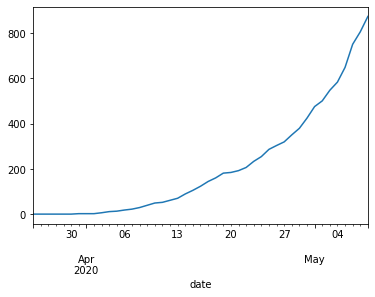

In [235]:
deaths.plot()
plt.show()

- Increasing trend of cases over time.
- There do not appears to be systematic seasonality to the cases for each day.
- There do not appear to be any obvious outliers.

### Histogram and Density Plot

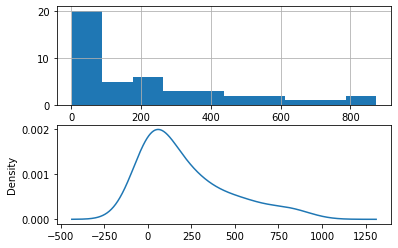

In [236]:
plt.figure(1)
plt.subplot(211)
deaths.hist()

plt.subplot(212)
deaths.plot(kind='kde')
plt.show()

- The distribution is not Guassian.
- The shape has a long right rail and may suggest an exponential distribution.

### Box and Whisker Plots

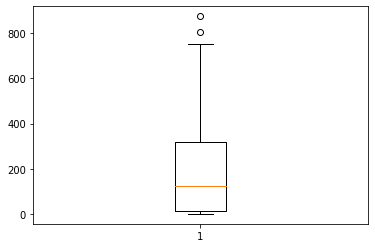

In [238]:
plt.boxplot(deaths)
plt.show()

- There are outliers on the top.

### Moving Average as Data Preparation

In [206]:
deaths = pd.Series(df['deaths'])
rolling = deaths.rolling(window=3) 
rolling_mean = rolling.mean() 
print(rolling_mean.head(10))

date
2020-03-25         NaN
2020-03-26         NaN
2020-03-27    1.000000
2020-03-28    1.000000
2020-03-29    1.000000
2020-03-30    1.000000
2020-03-31    1.666667
2020-04-01    2.333333
2020-04-02    3.000000
2020-04-03    4.333333
Name: deaths, dtype: float64


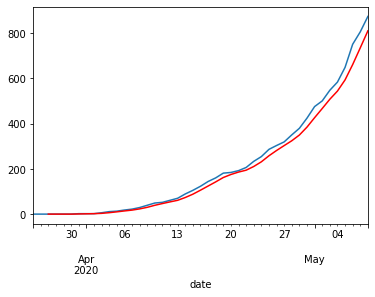

In [207]:
# plot original and transformed dataset 
deaths.plot() 
rolling_mean.plot(color='red') 
plt.show()

### Moving Average as Feature Engineering

predicted=1.000000, expected=1.000000
predicted=1.000000, expected=1.000000
predicted=1.000000, expected=1.000000
predicted=1.000000, expected=3.000000
predicted=1.666667, expected=3.000000
predicted=2.333333, expected=3.000000
predicted=3.000000, expected=7.000000
predicted=4.333333, expected=12.000000
predicted=7.333333, expected=14.000000
predicted=11.000000, expected=19.000000
predicted=15.000000, expected=23.000000
predicted=18.666667, expected=30.000000
predicted=24.000000, expected=40.000000
predicted=31.000000, expected=50.000000
predicted=40.000000, expected=53.000000
predicted=47.666667, expected=62.000000
predicted=55.000000, expected=71.000000
predicted=62.000000, expected=90.000000
predicted=74.333333, expected=106.000000
predicted=89.000000, expected=124.000000
predicted=106.666667, expected=145.000000
predicted=125.000000, expected=161.000000
predicted=143.333333, expected=182.000000
predicted=162.666667, expected=185.000000
predicted=176.000000, expected=193.000000
pred

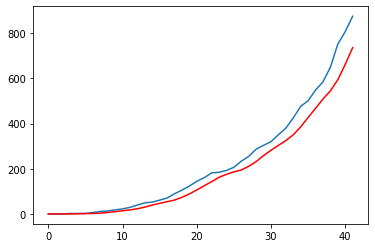

In [208]:
from sklearn.metrics import mean_squared_error

# prepare situation
X = deaths.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)]) 
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

# zoom plot
#pyplot.plot(test[:100]) pyplot.plot(predictions[:100], color='red') pyplot.show()

### Is your Time Series White Noise?

In [209]:
from pandas.plotting import autocorrelation_plot

In [210]:
deaths.describe()

# mean is not zero
# standard deviation is high

count     45.000000
mean     211.866667
std      242.619099
min        1.000000
25%       14.000000
50%      124.000000
75%      320.000000
max      874.000000
Name: deaths, dtype: float64

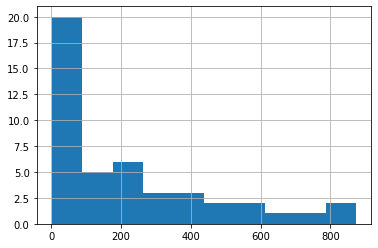

In [211]:
# histogram plot
deaths.hist()
plt.show()

# histogram is not a bell curve.

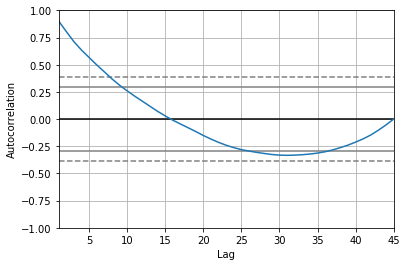

In [212]:
# autocorrelation
autocorrelation_plot(deaths)
plt.show()

# there are high correlations before day 9.

### Check Stationarity

In [213]:
from statsmodels.tsa.stattools import adfuller

In [214]:
# statistical test

# The null hypothesis of the test is that the time series is non-stationary.
# https://machinelearningmastery.com/time-series-data-stationary-python/
# https://en.wikipedia.org/wiki/Augmented_Dickey–Fuller_test

result = adfuller(deaths) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.282459
p-value: 0.998944
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610


### Time Series Components

Systematic Components:
- Level
- Trend
- Seasonality

Nos-Systematic Component:
- Noise


### Automatic Time Series Decomposition

### Additive Decomposition

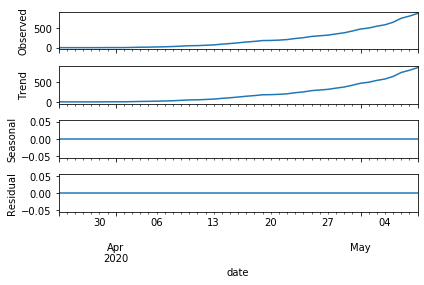

In [215]:
from statsmodels.tsa.seasonal import seasonal_decompose 

result = seasonal_decompose(deaths, model='additive', freq=1) 
result.plot()
plt.show()

### Multiplicative Decomposition

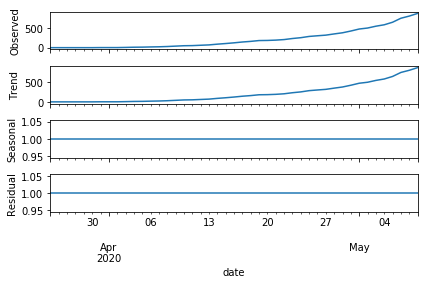

In [216]:
result = seasonal_decompose(deaths, model='multiplicative', freq=1) 
result.plot()
plt.show()

### Log transformation

In [222]:
result = adfuller(np.log(deaths)) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.001256
p-value: 0.286023
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


### Detrend by Model Fitting

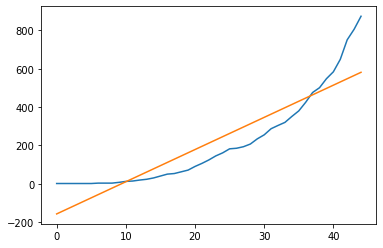

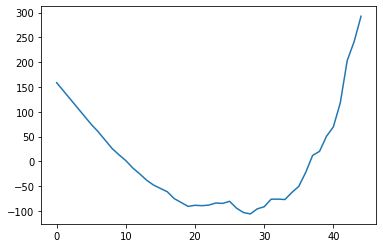

In [219]:
from sklearn.linear_model import LinearRegression

# fit linear model
X = [i for i in range(0, len(deaths))]
X = np.reshape(X, (len(X), 1))
y = deaths.values
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)

# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()

# detrend
detrended = [y[i]-trend[i] for i in range(0, len(deaths))]

# plot detrended
plt.plot(detrended)
plt.show()

In [220]:
detrended

[158.7043478260871,
 141.90566534914373,
 125.10698287220038,
 108.30830039525704,
 91.50961791831368,
 74.71093544137032,
 59.91225296442698,
 43.11357048748363,
 26.314888010540272,
 13.516205533596917,
 1.7175230566535618,
 -13.081159420289794,
 -24.87984189723312,
 -37.678524374176476,
 -47.47720685111983,
 -54.27588932806319,
 -61.07457180500654,
 -74.87325428194987,
 -82.67193675889325,
 -90.47061923583658,
 -88.26930171277996,
 -89.06798418972329,
 -87.86666666666667,
 -83.66534914361,
 -84.46403162055333,
 -80.26271409749671,
 -94.06139657444004,
 -102.86007905138342,
 -105.65876152832675,
 -95.45744400527013,
 -91.25612648221346,
 -76.05480895915684,
 -75.85349143610017,
 -76.6521739130435,
 -62.450856389986825,
 -50.249538866930266,
 -22.048221343873593,
 12.15309617918308,
 20.354413702239754,
 50.55573122529631,
 69.75704874835299,
 117.95836627140966,
 203.15968379446633,
 241.361001317523,
 292.56231884057956]

In [221]:
result = adfuller(detrended) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.503468
p-value: 0.984978
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
